The goal of this notebook is to explore multi-site classifiers with synthetic "concordance" features. i.e. features which explicitly encode whether or not an OTU is present in both sites, absent in both sites, or discordant.

The motivation behind this is to explicitly encode the expected informative structure into the classifier, rather than hope that the RF will figure it out itself (which is probably not possible with only ~50 patients)

In [110]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from scipy.stats import fisher_exact

%matplotlib inline

In [111]:
import os, sys
src_dir = os.path.normpath(os.path.join(os.getcwd(), '../util'))
sys.path.append(src_dir)
import util

# Load in data

In [112]:
fotu = '../../data/clean/rosen.otu_table.rel_abun.clean'
fmeta = '../../data/clean/rosen.metadata.clean'

otu = pd.read_csv(fotu, sep='\t', index_col=0)
meta = pd.read_csv(fmeta, sep='\t', index_col=0)
otu.shape

(586, 1578)

In [113]:
fpreva = '../../data/analysis/prevalence.partial_corrs.nthresh10-qthresh01-rthresh0.txt'
preva = pd.read_csv(fpreva, sep='\t')
preva.head()

,otu,prevalence_exchange,meta_var,meta_val,site_comparison,n_patients
0,k__Bacteria;p__;c__;o__;f__;g__;s__;d__denovo364,0.27,all_patients,all_patients,bal-gastric_fluid,100
1,k__Bacteria;p__Actinobacteria;c__Actinobacteri...,0.26,all_patients,all_patients,bal-gastric_fluid,100
2,k__Bacteria;p__Actinobacteria;c__Actinobacteri...,0.16,all_patients,all_patients,bal-gastric_fluid,100
3,k__Bacteria;p__Actinobacteria;c__Actinobacteri...,0.43,all_patients,all_patients,bal-gastric_fluid,100
4,k__Bacteria;p__Actinobacteria;c__Actinobacteri...,0.20,all_patients,all_patients,bal-gastric_fluid,100


## Prepare lung-throat table

In [114]:
keepotus = preva\
    .query('meta_var == "all_patients"')\
    .query('site_comparison == "bal-throat_swab"')\
    ['otu']\
    .unique()

otu = otu[keepotus]
otu.shape

(586, 13)

In [115]:
mbs_col = 'mbs_consolidated'

# Check that each aspiration patient has only one sample per site
meta.dropna(subset=[mbs_col]).groupby(['subject_id', 'site']).size().max()

1

In [116]:
meta = meta.dropna(subset=[mbs_col])

tidydf = util.tidyfy_otu(otu, meta, mbs_col, cols=['ppi_consolidated'])
tidydf.head()

Tidying data... 
Finished.


,sample,otu,abun,mbs_consolidated,site,subject_id,ppi_consolidated,otu_w_site
35,02-096-6G,k__Bacteria;p__Actinobacteria;c__Actinobacteri...,0.0,Normal,gastric_fluid,02-096-6,off,k__Bacteria;p__Actinobacteria;c__Actinobacteri...
621,02-096-6G,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o_...,0.0,Normal,gastric_fluid,02-096-6,off,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o_...
1207,02-096-6G,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o_...,0.0,Normal,gastric_fluid,02-096-6,off,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o_...
1793,02-096-6G,k__Bacteria;p__Bacteroidetes;c__Flavobacteriia...,0.0,Normal,gastric_fluid,02-096-6,off,k__Bacteria;p__Bacteroidetes;c__Flavobacteriia...
2379,02-096-6G,k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactob...,0.0,Normal,gastric_fluid,02-096-6,off,k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactob...


In [117]:
def make_concordance_df(site1, site2):
    ## Get subjects with both sites
    tmp = tidydf\
        .query('(site == @site1) | (site == @site2)')\
        .groupby(['subject_id', 'otu'])\
        .size()
    tmp = tmp[tmp == 2].reset_index()

    subjs = tmp['subject_id'].unique().tolist()

    ## Make separate BAL and throat dataframes
    bal = tidydf\
        .query('site == @site1')\
        .query('subject_id == @subjs')\
        .pivot(index='subject_id', columns='otu_w_site',
               values='abun')

    thr = tidydf\
        .query('site == @site2')\
        .query('subject_id == @subjs')\
        .pivot(index='subject_id', columns='otu_w_site',
               values='abun')

    ## Even though pandas should have done this already, double-make-sure
    ## that rows and columns match
    # Remove site label appended to OTUs
    bal.columns = [c.split('--')[0] for c in bal.columns]
    thr.columns = [c.split('--')[0] for c in thr.columns]
    # Re-order bal so it matches thr
    bal = bal.loc[thr.index, thr.columns]
    
    # Get concordance values: if both are greater than 0 OR both are 0, returns 1. Otherwise 0
    concordance = ((bal > 0) == (thr > 0)).astype(int)

    return concordance

## Classify!

In [118]:
# Define some global vars
tmp = meta[['subject_id', 'mbs_consolidated']].drop_duplicates()
# metadict has {subject_id: aspiration_status}
metadict = dict(zip(tmp['subject_id'].values, tmp['mbs_consolidated'].values))
aspdict = {'Normal': 0, 'Aspiration/Penetration': 1}
random_state = 123456

In [119]:
## Classify!
site1 = 'bal'
site2 = 'throat_swab'
concordance = make_concordance_df(site1, site2)
X = concordance.values
Y = [aspdict[metadict[s]] for s in concordance.index]

In [120]:
rf = RandomForestClassifier(n_estimators=1000, random_state=random_state)

results = util.cv_and_roc(rf, X, Y, random_state=random_state)

('bal', 'throat_swab')
0.736
(4.3174603174603172, 0.022241295691722476)


,pred 0,pred 1
true 0,17,7
true 1,9,16


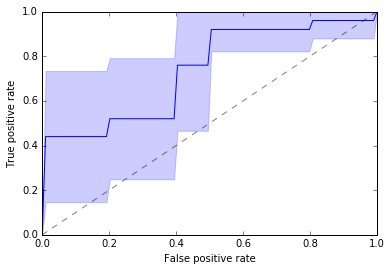

In [121]:
print(site1, site2)
print(np.mean(results['auc_list']))
util.plot_auc_from_list(results['tpr_list'], results['mean_fpr'])
print(fisher_exact(results['conf_mat']))
results['conf_mat']

## Lung-gastric

In [122]:
fotu = '../../data/clean/rosen.otu_table.rel_abun.clean'
otu = pd.read_csv(fotu, sep='\t', index_col=0)
print(otu.shape)
keepotus = preva\
    .query('meta_var == "all_patients"')\
    .query('site_comparison == "bal-gastric_fluid"')\
    ['otu']\
    .unique()
otu = otu[keepotus]
print(otu.shape)
tidydf = util.tidyfy_otu(otu, meta, mbs_col, cols=['ppi_consolidated'])

(586, 1578)
(586, 75)
Tidying data... 
Finished.


In [123]:
site1 = 'bal'
site2 = 'gastric_fluid'
concordance = make_concordance_df(site1, site2)
X = concordance.values
Y = [aspdict[metadict[s]] for s in concordance.index]

In [124]:
rf = RandomForestClassifier(n_estimators=1000, random_state=random_state)

results = util.cv_and_roc(rf, X, Y, random_state=random_state)

0.56
(0.93333333333333335, 1.0)


,pred 0,pred 1
true 0,15,15
true 1,15,14


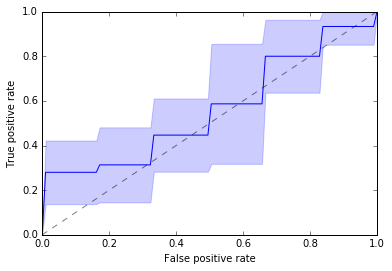

In [125]:
util.plot_auc_from_list(results['tpr_list'], results['mean_fpr'])
print(np.mean(results['auc_list']))
print(fisher_exact(results['conf_mat']))
results['conf_mat']

## Throat-gastric

In [126]:
fotu = '../../data/clean/rosen.otu_table.rel_abun.clean'
otu = pd.read_csv(fotu, sep='\t', index_col=0)
print(otu.shape)
keepotus = preva\
    .query('meta_var == "all_patients"')\
    .query('site_comparison == "gastric_fluid-throat_swab"')\
    ['otu']\
    .unique()
otu = otu[keepotus]
print(otu.shape)
tidydf = util.tidyfy_otu(otu, meta, mbs_col, cols=['ppi_consolidated'])

(586, 1578)
(586, 122)
Tidying data... 
Finished.


In [127]:
site1 = 'throat_swab'
site2 = 'gastric_fluid'
concordance = make_concordance_df(site1, site2)
X = concordance.values
Y = [aspdict[metadict[s]] for s in concordance.index]

In [128]:
rf = RandomForestClassifier(n_estimators=1000, random_state=random_state)

results = util.cv_and_roc(rf, X, Y, random_state=random_state)

('throat_swab', 'gastric_fluid')
0.502210884354
(1.0109890109890109, 1.0)


,pred 0,pred 1
true 0,23,13
true 1,21,12


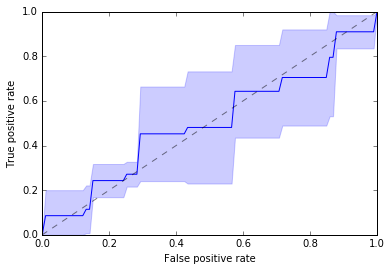

In [129]:
print(site1, site2)
print(np.mean(results['auc_list']))
util.plot_auc_from_list(results['tpr_list'], results['mean_fpr'])
print(fisher_exact(results['conf_mat']))
results['conf_mat']

# Classifiers based on entire community

Not just exchanged OTUs. But let's still consider concordance. Question we're trying to answer is: are these bugs specific biomarkers, or will some subset do?

These classifiers should work at least as well as the ones above (well, except that the ones above were limited to patients with both sites sequenced, so maybe not...)

In [130]:
fotu = '../../data/clean/rosen.otu_table.rel_abun.clean'
otu = pd.read_csv(fotu, sep='\t', index_col=0)

tidydf = util.tidyfy_otu(otu, meta, mbs_col, cols=['ppi_consolidated'])

Tidying data... 
Finished.


In [131]:
site1 = 'bal'
site2 = 'throat_swab'
concordance = make_concordance_df(site1, site2)
X = concordance.values
Y = [aspdict[metadict[s]] for s in concordance.index]

In [132]:
rf = RandomForestClassifier(n_estimators=1000, random_state=random_state)

results = util.cv_and_roc(rf, X, Y, random_state=random_state)

('bal', 'throat_swab')
0.73
(5.333333333333333, 0.009595048587550864)


,pred 0,pred 1
true 0,18,6
true 1,9,16


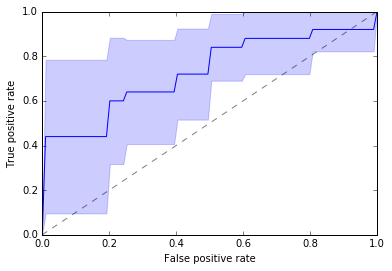

In [133]:
print(site1, site2)
print(np.mean(results['auc_list']))
util.plot_auc_from_list(results['tpr_list'], results['mean_fpr'])
print(fisher_exact(results['conf_mat']))
results['conf_mat']

In [134]:
site1 = 'bal'
site2 = 'gastric_fluid'
concordance = make_concordance_df(site1, site2)
X = concordance.values
Y = [aspdict[metadict[s]] for s in concordance.index]

In [135]:
rf = RandomForestClassifier(n_estimators=1000, random_state=random_state)

results = util.cv_and_roc(rf, X, Y, random_state=random_state)

('bal', 'gastric_fluid')
0.656111111111
(3.3846153846153846, 0.035217385694921582)


,pred 0,pred 1
true 0,22,8
true 1,13,16


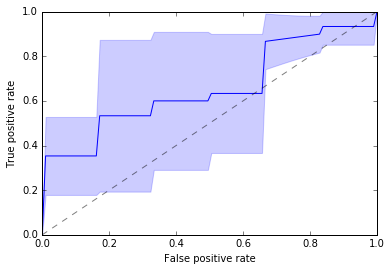

In [136]:
print(site1, site2)
print(np.mean(results['auc_list']))
util.plot_auc_from_list(results['tpr_list'], results['mean_fpr'])
print(fisher_exact(results['conf_mat']))
results['conf_mat']

In [137]:
site1 = 'throat_swab'
site2 = 'gastric_fluid'
concordance = make_concordance_df(site1, site2)
X = concordance.values
Y = [aspdict[metadict[s]] for s in concordance.index]

In [138]:
rf = RandomForestClassifier(n_estimators=1000, random_state=random_state)

results = util.cv_and_roc(rf, X, Y, random_state=random_state)

('throat_swab', 'gastric_fluid')
0.72074829932
(5.9800000000000004, 0.00070136405099212925)


,pred 0,pred 1
true 0,26,10
true 1,10,23


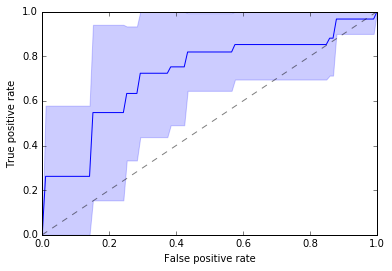

In [139]:
print(site1, site2)
print(np.mean(results['auc_list']))
util.plot_auc_from_list(results['tpr_list'], results['mean_fpr'])
print(fisher_exact(results['conf_mat']))
results['conf_mat']